In [2]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw, Lipinski
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor, rdMolDescriptors, rdFMCS, AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize

from tqdm import tqdm
from rdkit.ML.Cluster.Butina import ClusterData
from rdkit.DataManip.Metric import GetTanimotoDistMat
from rdkit.SimDivFilters.rdSimDivPickers import HierarchicalClusterPicker, ClusterMethod

from IPython.core.display import display, HTML, Math

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import mols2grid

import time
rdDepictor.SetPreferCoordGen(True)

import rdkit
%pylab inline
print(rdkit.__version__)

cmap = plt.get_cmap("tab10")


Populating the interactive namespace from numpy and matplotlib
2020.09.1


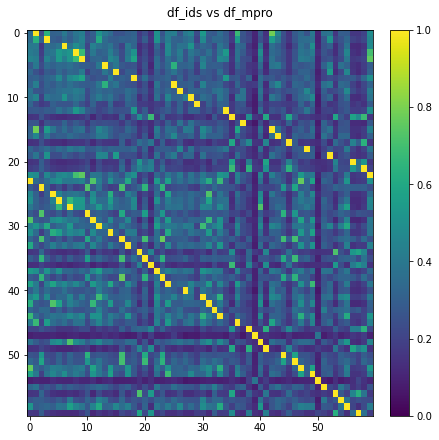

,smiles,membership,fps,enamine,nonchiral
2,[H]OC[C@H](CN([H])C(=O)c1cc(F)c(C)cc1F)N([H])C...,64,"[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...",NaN,Cc1cc(F)c(C(=O)NCC(CO)NCc2cncs2)cc1F
10,[H]OC[C@H](CN([H])C(=O)Cc1cc(F)ccc1F)N([H])Cc1...,42,"[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...",NaN,O=C(Cc1cc(F)ccc1F)NCC(CO)NCc1ccns1
16,[H]OC[C@H](CN([H])C(=O)c1cccnc1C)N([H])Cc1cc(F...,36,"[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...",NaN,Cc1ncccc1C(=O)NCC(CO)NCc1cc(F)ccc1F
19,[H]N([H])C(=O)c1ccc(C(=O)N([H])C[C@@H]2CCN2C(=...,33,"[1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,NC(=O)c1ccc(C(=O)NCC2CCN2C(=O)c2ccns2)[nH]1
20,[H]OC[C@H](CN([H])C(=O)c1cc(C)sn1)N([H])Cc1ccc...,32,"[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...",NaN,Cc1cc(C(=O)NCC(CO)NCc2ccc(F)c(F)c2)ns1
21,[H]N([H])C(=O)c1cc(C(=O)N(C)[C@@H]2CCN(C(=O)c3...,31,"[1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,CN(C(=O)c1c[nH]c(C(N)=O)c1)C1CCN(C(=O)c2cocn2)C1
22,[H]OC[C@H](c1ccc(F)cc1)N([H])C(=O)c1ccc(Cl)c(S...,30,"[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",NaN,NS(=O)(=O)c1cc(C(=O)NC(CO)c2ccc(F)cc2)ccc1Cl
23,[H]OC[C@@H](CN([H])C(=O)c1c(F)ccc(C)c1F)N([H])...,30,"[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, ...",NaN,Cc1ccc(F)c(C(=O)NCC(CO)NCc2nccs2)c1F
30,[H]O[C@H](CN([H])S(=O)(=O)c1cccc(C(=O)N([H])[H...,28,"[1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",NaN,NC(=O)c1cccc(S(=O)(=O)NCC(O)c2c(F)cccc2Cl)c1
41,[H]N([H])C(=O)c1ccc(C(=O)N(C)C[C@H](C)N([H])C(...,26,"[1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN,CC(CN(C)C(=O)c1ccc(C(N)=O)[nH]1)NC(=O)c1ccsn1


In [8]:
df_ids = pd.read_csv('/home/wjm41/ml_physics/frag-pcore-screen/data/mpro_mols.csv')

df_mpro = pd.read_csv(
    '/home/wjm41/ml_physics/frag-pcore-screen/data/EnamineREAL/topN/mpro_taut_picks_constrained.csv')

df_ids['fps'] = [rdMolDescriptors.GetMorganFingerprintAsBitVect(
        Chem.MolFromSmiles(smi), 2, 2048, useFeatures=True) for smi in df_ids["smiles"]]  # pharmacophore fingerprint
df_mpro['fps'] = [rdMolDescriptors.GetMorganFingerprintAsBitVect(
        Chem.MolFromSmiles(smi), 2, 2048, useFeatures=True) for smi in df_mpro["smiles"]]  # pharmacophore fingerprint

sim_mat = np.empty((len(df_ids), len(df_mpro)))
for i in range(len(df_ids)):
    sim_mat[i] = np.array(
        DataStructs.BulkTanimotoSimilarity(df_ids['fps'].values[i], df_mpro['fps'].values))

fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
fig.suptitle('df_ids vs df_mpro')
cax = ax.matshow(sim_mat, aspect="auto", vmin=0, vmax=1)
ax.xaxis.set_ticks_position('bottom')
fig.colorbar(cax)
plt.show()

for ind in range(len(df_mpro)):
    df_mpro.at[np.argmax(sim_mat[ind]),
               'enamine'] = df_ids.iloc[ind]['enamine']
    df_mpro.at[np.argmax(sim_mat[ind]), 'nonchiral'] = df_ids.iloc[ind]['smiles']

display(df_mpro[df_mpro['enamine'].isnull()])
df_mpro['mol'] = df_mpro['smiles'].apply(Chem.MolFromSmiles)

pick_grid = mols2grid.display(df_mpro, template="pages", smiles_col='smiles', mol_col='mol',
                              n_rows=15, n_cols=4, subset=["img", "membership"], transform={"membership": lambda x: f"membership: {x}"},
                              tooltip=['smiles'],
                              maxMols=60, size=(300, 150))

display(pick_grid)


# Visualise all clustered molecules & picks

In [15]:
df_clustered = pd.read_csv(
    '/home/wjm41/ml_physics/frag-pcore-screen/data/EnamineREAL/topN/mpro_taut_clustered.csv')
df_clustered['mol'] = df_clustered['smiles'].apply(Chem.MolFromSmiles)
# df_clustered['fps'] = [rdMolDescriptors.GetMorganFingerprintAsBitVect(
#     Chem.MolFromSmiles(smi), 2, 2048, useFeatures=True) for smi in df_clustered["smiles"]]  # pharmacophore fingerprint

df_picks = pd.read_csv(
    '/home/wjm41/ml_physics/frag-pcore-screen/data/EnamineREAL/topN/mpro_taut_picks_constrained_new.csv')
df_picks['mol'] = df_picks['smiles'].apply(Chem.MolFromSmiles)

pick_grid = mols2grid.display(df_picks, template="pages", smiles_col='nonchiral', mol_col='mol',
                                 n_rows=15, n_cols=4, subset=["img", "membership"], transform={"membership": lambda x: f"membership: {x}"},
                                 tooltip=['nonchiral'],
                                 maxMols=60, size=(300, 150))
display(pick_grid)
# pd.set_option('display.width', None)
# pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
display(df_picks[['smiles', 'membership']])
# cluster_grid = mols2grid.display(df_clustered, template="pages", smiles_col='smiles', mol_col='mol',
#                   n_rows=15, n_cols=4, subset=["img", "cluster"], transform={"cluster": lambda x: f"cluster: {x}"},
#                   tooltip=['smiles'],
#                   maxMols=60, size=(300, 150))
# display(cluster_grid)



/rds-d2/user/wjm41/hpc-work/conda/envs/fresco/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


,smiles,membership
0,[H]OC[C@@H](c1cc(F)ccc1F)N([H])C(=O)N([H])c1cccc(C(=O)N([H])[H])c1,100
1,[H]N([H])S(=O)(=O)c1ccc(F)c(CN([H])S(=O)(=O)c2ccccc2Cl)c1,81
2,[H]OC[C@H](CN([H])C(=O)c1cc(F)c(C)cc1F)N([H])Cc1cncs1,64
3,[H]N(Cc1ccc(F)c(Cl)c1)C(=O)c1cc(S(=O)(=O)N([H])[H])ccc1F,52
4,[H]N([H])C(=O)[C@H](c1ccc(F)cc1)N([H])C(=O)N([H])c1cc(Br)ccc1OC,52
5,[H]OC[C@@H](c1ccccc1)N([H])C(=O)C(=O)N([H])c1cc(F)ccc1F,48
6,[H]N(C(=O)COC(=O)c1ccc(Cl)cc1)c1cccc(S(=O)(=O)N([H])[H])c1,45
7,[H]O[C@H](CN([H])C(=O)C(=O)N([H])c1cc(Br)ccc1F)c1cccc(F)c1,44
8,[H]N(Cc1cccc(N([H])C(C)=O)c1)C(=O)C(=O)N([H])c1cccc(F)c1,43
9,[H]N([H])C(=O)c1ccc(F)c(N([H])C(=O)C(=O)N([H])Cc2ccccc2)c1,43


[1.         1.41421356 1.         0.70710678 0.70710678 0.70710678
 1.11803399 1.11803399 0.5        0.5        1.         1.41421356
 1.         0.70710678 0.5       ]
((3, 0, 1, 2, 4, 5),)


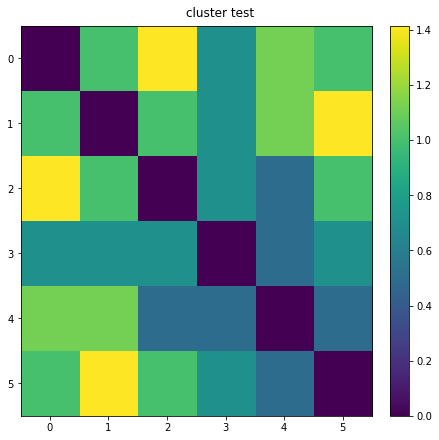

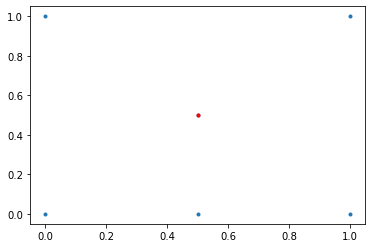

In [47]:
from sklearn.metrics import pairwise_distances

x = np.array([
    [0,1],
    [1,1],
    [1,0],
    [0.5,0.5],
    [0.5,0],
    [0,0]
    ])

d_mat_test = pairwise_distances(x)
fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)
fig.suptitle('cluster test')
cax = ax.matshow(d_mat_test, aspect="auto")
ax.xaxis.set_ticks_position('bottom')
fig.colorbar(cax)
fig = plt.figure()

lower_tril = np.tril(d_mat_test, k=-1).flatten()
lower_tril = lower_tril[lower_tril!=0]
print(lower_tril)
clusters = ClusterData(lower_tril, nPts=len(x), 
    isDistData=True, distThresh=1.0, reordering=True)
print(clusters)

centroid = clusters[0][0]
plt.plot(x.T[0], x.T[1], '.')
plt.plot(x[centroid].T[0], x[centroid].T[1], '.', color='red')
plt.show()
